# The Machine Learning Model
After spending the last two labs focusing on the learning objective and learning algorithm, now we will focus on the learning model. Some of you may have wondered when we were training our linear regression models: "Is there a model that could express *any* function parametrized by some parameters $\vec{\theta}$?" And the answer is yes! This model is called a multilayer perceptron or sometimes a feed-forward neural network.

## Single-layer Perceptrons are Linear Models
First we will focus on the single-layer perceptron before we start adding multiple layers to help us in building an intuition for how feed-forward neural networks work. Mathematically, a single-layer perceptron predicting a one-dimensional output can be expressed as:

$$
\hat{y} = \mathcal{f}\left(\vec{\theta}\cdot\vec{x} + b\right)
$$
where $\mathcal{f}$ is what is called the "activation function" or "nonlinearity". However, let's focus on the argument of the activation function, $\vec{\theta}\cdot\vec{x} + b$, first. Does this look familiar? It should! This is the function for multidimensional linear regression. Another word for this function is the hyperplane. The y-intercept, $b$, is sometimes generalized to being called the bias. In fact, we can get rid of the bias term by simply including it with our $\vec{\theta}$ vector and appending a 1 to our input vector, $\vec{x}$.
$$
\vec{\theta} \cdot \vec{x} = \theta_1 x_1 + \theta_2 x_2 + ... + \theta_n x_n + b \cdot 1
$$
Now let's look at the simple, 2D hyperplane first.

In [1]:
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator

import torch
from torch import nn
import numpy as np

In [2]:
# Pretty plotting config
%run plot_conf.py

In [3]:
plt_style()

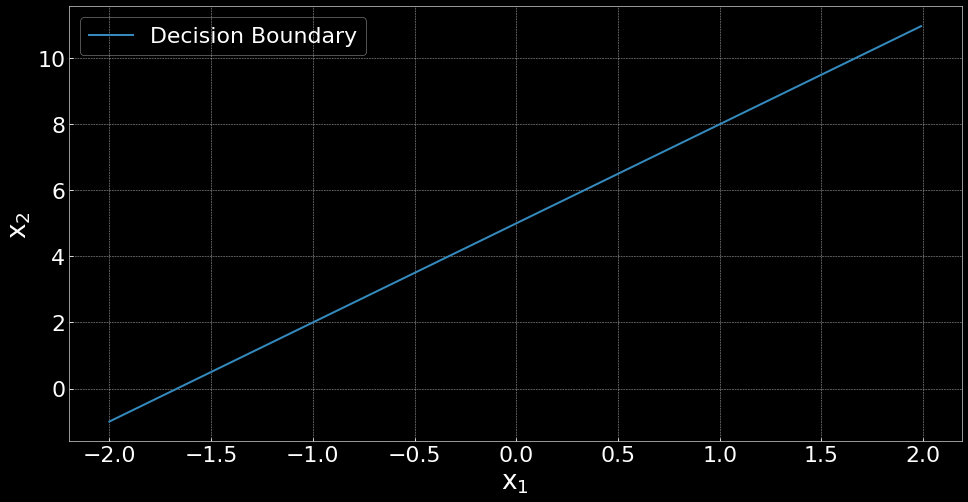

In [4]:
slope = 3
bias = 5

x = torch.arange(-2, 2, 0.01)
num_x = len(x)

decision_boundary = slope * x + bias
plt.plot(x.detach().numpy(), decision_boundary.detach().numpy(), label='Decision Boundary')
plt.ylabel('$\mathregular{x_2}$')
plt.legend()
plt.xlabel('$\mathregular{x_1}$')
plt.show()

Now let's assume we have some data that can belong to two different classes, class red ($\hat{y} = -1$) and class blue ($\hat{y} = 1$), and we can separate these two classes by drawing a 2D hyperplane between the two. In this case, we can say that *class red and class blue are* **linearly separable**. What this means is we can draw a line (perhaps a multidimensional line... *cough* hyperplane) that can separate the two classes where one class will be "above" (greater than) the line and the other class will be "below" (less than) the line. This multidimensional line then takes on a new name which is called the **decision boundary**. Let's now generate some data that is linearly separable.

In [5]:
N = 100 # how many data points to generate

In [6]:
# this will randomly sample x1 and x2 values for our data points
data_x1 = torch.distributions.uniform.Uniform(torch.Tensor([-2]),torch.Tensor([2])).sample(torch.Size([N]))
data_x2 = torch.distributions.uniform.Uniform(torch.Tensor([min(decision_boundary)]),torch.Tensor([max(decision_boundary)])).sample(torch.Size([N]))

# this combines/concatenates the x1 and x2 values so that it is a single torch tensor 
data = torch.cat((data_x1, data_x2),dim=1)

In [7]:
# true values our neural network is going to learn
slope_true = 1.15
y_intercept_true = 2

In [13]:
# split the data into red and blue classes
red_class = torch.Tensor()
blue_class = torch.Tensor()
for i in range(len(data)):
    if data[i][1] < data[i][0] * 1.15 + 2:
        red_class = torch.cat((red_class, data[i]))
    else:
        blue_class = torch.cat((blue_class, data[i]))
        
# reshape so that they are in a N x 2 array
red_class = red_class.reshape(int(len(red_class) / 2), 2)
blue_class = blue_class.reshape(int(len(blue_class) / 2), 2)

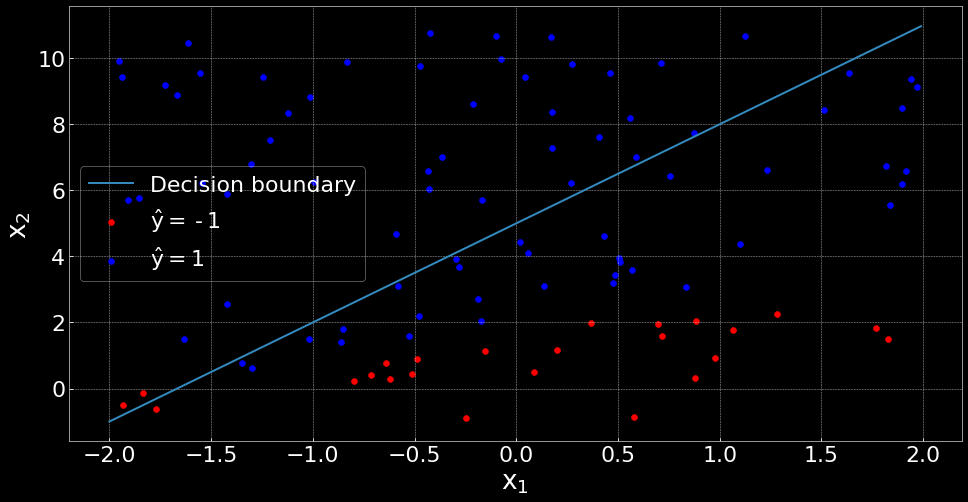

In [17]:
# plot the red data points
plt.scatter(red_class[:, 0].detach().numpy(), red_class[:, 1].detach().numpy(), color='red', label='$\mathregular{\hat{y} = -1}$')

# plot the blue data points
plt.scatter(blue_class[:, 0].detach().numpy(), blue_class[:, 1].detach().numpy(), color='blue', label='$\mathregular{\hat{y} = 1}$')

# plot the decision boundary
plt.plot(x.detach().numpy(), decision_boundary.detach().numpy(), label='Decision boundary')

# label axes and crap
plt.ylabel('$\mathregular{x_2}$')
plt.legend()
plt.xlabel('$\mathregular{x_1}$')
plt.show()

Now we can see that there does exist some decision boundary that will separate our two classes, red and blue. Clearly our current decision boundary is not optimal, meaning that we have a large rate of false positives (red data points being classified as blue) and false negatives (blue data points being classified as red). So we must then use gradient descent to optimize this decision boundary and (perhaps) use binary cross entropy as our loss function! But wait...this seems like we are performing linear regression here... linear *regression* is used to perform regression **not classification**! How can we use a linear regression model to perform classification? Let's delve into this deeper...

For those of you who don't know or perhaps don't remember, a hyperplane can be described in three different ways.

1) You can describe it as the N-dimensional hyperplane that passes through your N points in this N-dimensional space  
2) define it as the intercept with the (0,0,...0) point and its slopes in all the different directions  
3) *or* as the vector perpendicular to the surface of the plane and an intercept at the (0, 0, ..., 0) point. 

Namely, for a hyperplane
$$
b = a x_1 + b x_2 = \vec{\theta} \cdot \vec{x}
$$
The vector $\vec{\theta}$ is the vector that is perpendicular to the surface of the hyperplane!

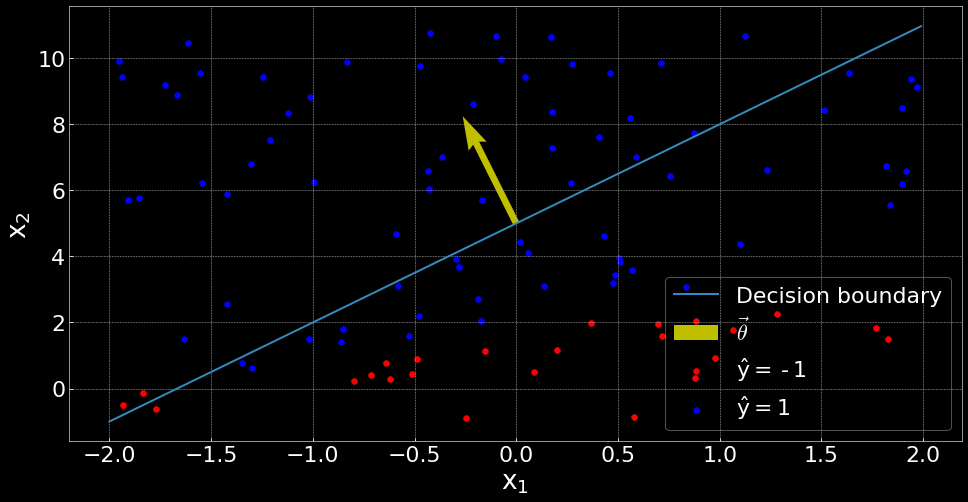

In [19]:
# we want the theta vector lying on the decision boundary so lets shift it up by the y-intercept
offset = torch.tensor([0.0, bias]) 

# 5 = -3*x_1 + 1*x_2 from above (re-arrange x_2 = m * x_1 + b)
theta_vec = torch.tensor([-slope, 1.0]) + offset 

# shift the origin of the vector up so it starts at the decision boundary
origin = np.array([[0], [0]]) + offset.reshape(2, 1) 

# plot the theta vector
plt.quiver(*origin, theta_vec[0].detach().numpy(), theta_vec[1].detach().numpy(), color='y', scale=50, label=r'$\vec{\theta}$')

# plot red data
plt.scatter(red_class[:, 0].detach().numpy(), red_class[:, 1].detach().numpy(), color='red', label='$\mathregular{\hat{y} = -1}$')

# plot blue data
plt.scatter(blue_class[:, 0].detach().numpy(), blue_class[:, 1].detach().numpy(), color='blue', label='$\mathregular{\hat{y} = 1}$')

# plot decision boundary
plt.plot(x.detach().numpy(), decision_boundary.detach().numpy(), label='Decision boundary')
plt.ylabel('$\mathregular{x_2}$')
plt.legend()
plt.xlabel('$\mathregular{x_1}$')
plt.show()

We can also then show that
$$
\vec{\theta} \cdot \vec{x} = \lVert \vec{\theta} \rVert \ \lVert \vec{x} \rVert \ cos(\alpha)
$$

where $\alpha$ is defined as the angle between the vectors $\vec{\theta}$ and $\vec{x}$. Remember that your inputs are indeed vectors. You can visualize this vector by drawing a line from the origin to the data point of interest. Now, we can turn the $\vec{\theta}$ vector into a unit vector since the magnitude of the vector $\vec{\theta}$ does not change the decision boundary. Therefore, the argument of the activation function for a single layer perceptron can now be viewed as

$$
f\left(\lVert \vec{x} \rVert \ cos(\alpha) \right)
$$

Let's examine this cosine term. For any data point residing "above" our decision boundary, the angle between the vectors $\vec{\theta}$ and $\vec{x}$ will be less than 90 degrees. Therefore, the argument of our activation function will always be positive. Conversely, for any data point residing "below" our decision boundary, the angle between the two vectors will be greater than 90 degrees, meaning this will always return a negative value for our activation function! Clearly, we then need an activation function of the form

$$
f(x) = \left\{
\begin{array}{ll}
    1 & x > 0 \\
    -1 & x < 0 \\
\end{array}
\right. $$

The first example that probably comes to your mind is the sign function!

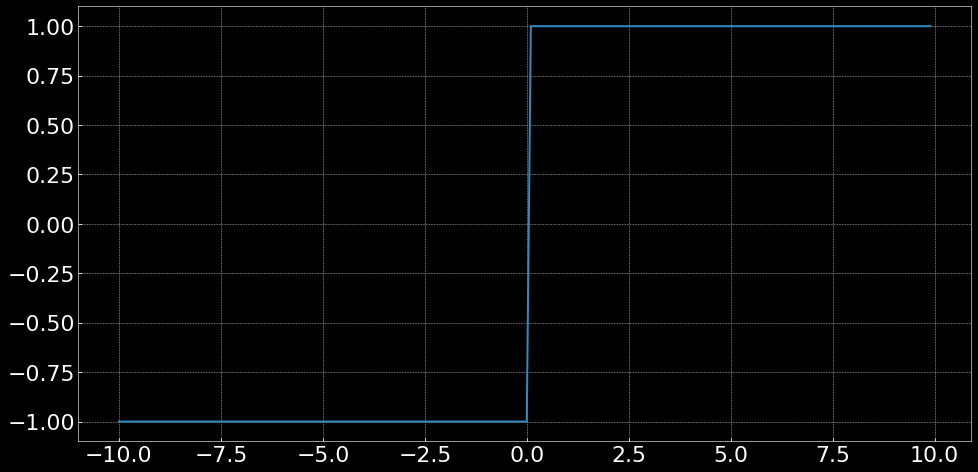

In [20]:
x = np.arange(-10, 10, 0.1)
y = np.sign(x)
plt.plot(x, y)

However, there's a problem with this function... do you spot it? Actually, maybe there's multiple problems with this "activation" function. The first problem would be that the derivative of this function is zero nearly everywhere. This means when we optimize our model's parameters using a gradient-descent based optimizer we will be unable to learn since the gradient is zero. The second problem is the only place where the gradient is non-zero is where it is undefined! This is also not a good property to have of your gradient. So maybe there's a function that smooths this out and doesn't have vanishing/exploding gradients?

## The tanh Activation Function

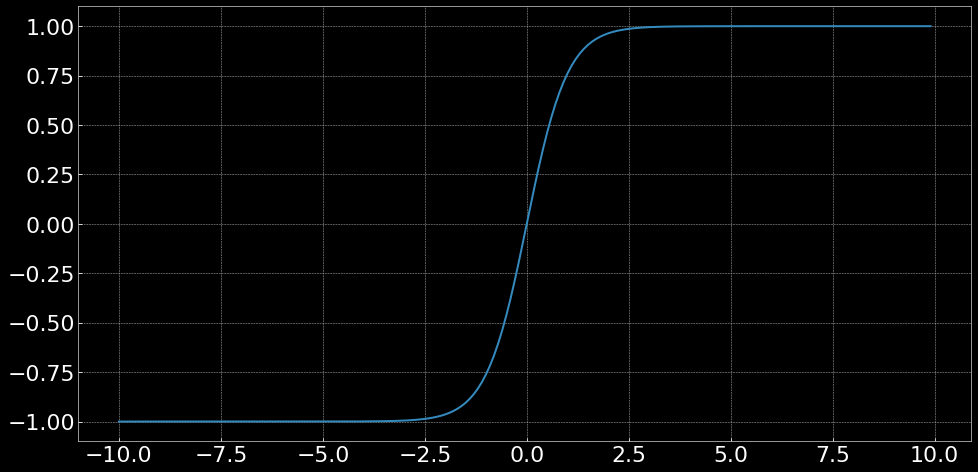

In [21]:
y = np.tanh(x)
plt.plot(x, y)

## The Sigmoid Activation Function

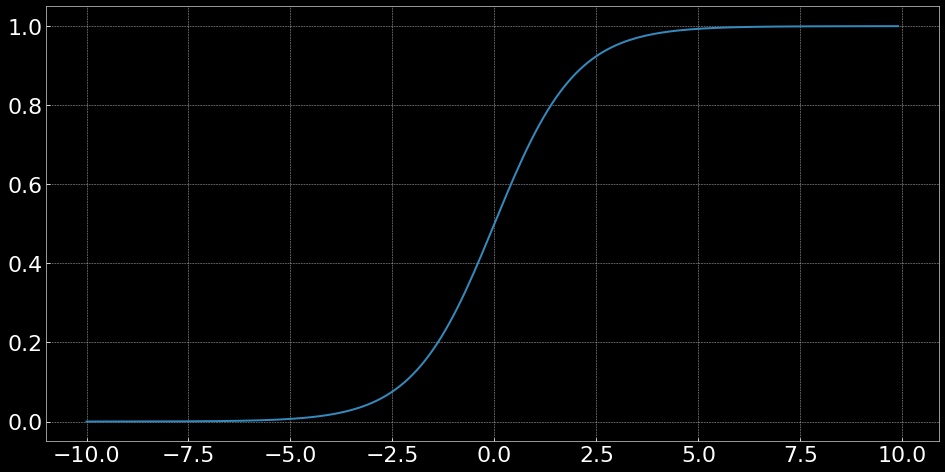

In [22]:
y = 1 / (1 + np.exp(-x))
plt.plot(x, y)

These types of activation functions are typically called "sigmoidal" activation functions since they look like the sigmoid activation function. The only "real" difference between the two is that the sigmoid activation function is used for purposes when you want the output of a network to correspond to some probabilities (usually in theoretical work). However, we can always make a tanh look like a sigmoid by scaling and shifting

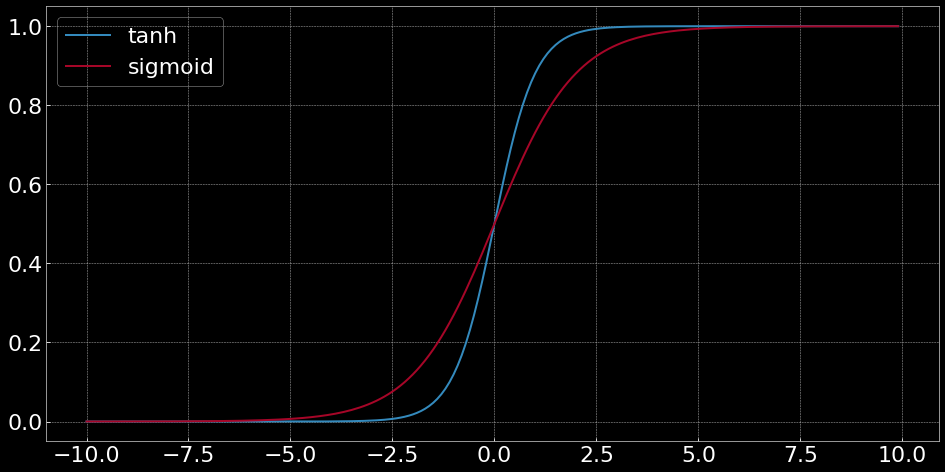

In [23]:
y = (np.tanh(x) + 1) / 2
plt.plot(x, y, label='tanh')
y = 1 / (1 + np.exp(-x))
plt.plot(x, y, label='sigmoid')
plt.legend()

However, there's some other problems with these activation functions that are maybe not quite as obvious. Computing these activation functions outputs is actually terribly slow. The reason for this is that computing `np.exp` or `np.tanh` is very computationally expensive. These functions cannot be trivially calculated with boolean gates. Therefore, we would perhaps like an activation function that is much quicker to compute. The first example that came to people's minds was the Rectified Linear Unit or ReLU for short

In [24]:
%%timeit
np.tanh(x)

9.28 µs ± 312 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [25]:
%%timeit
1 / (1 + np.exp(-x))

13.5 µs ± 182 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [26]:
%%timeit
# ReLU
x[x<0] = 0

2.46 µs ± 116 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


## ReLU

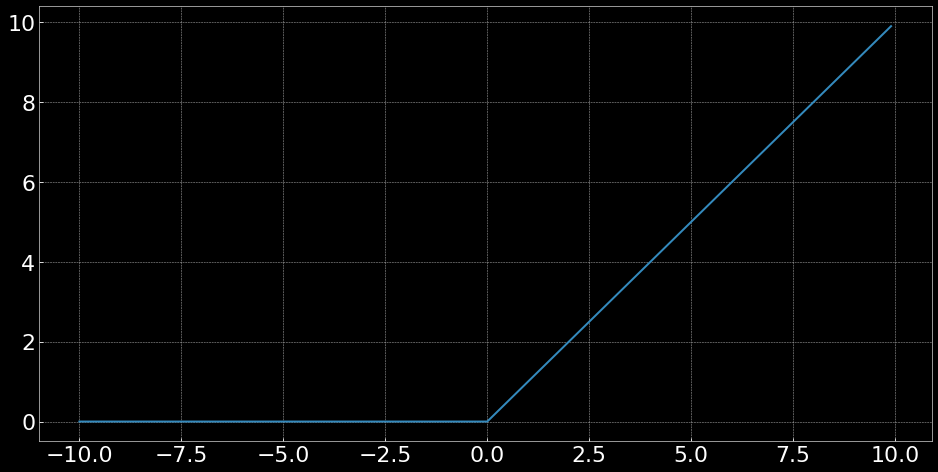

In [27]:
x = np.arange(-10, 10, 0.1)
y = np.arange(-10, 10, 0.1)
y[y < 0] = 0
plt.plot(x, y)

However, you can see that we got back to where we started! Now we have vanishing gradients all over again! The fix here is very simple. We just add a small positive slope on the $x < 0$ portion of the function. This new function is coined "Leaky ReLU".

In [28]:
%%timeit
# Leaky ReLU
flag = x < 0
x[flag] = 0.1 * x[flag]

4.18 µs ± 156 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


## Leaky ReLU

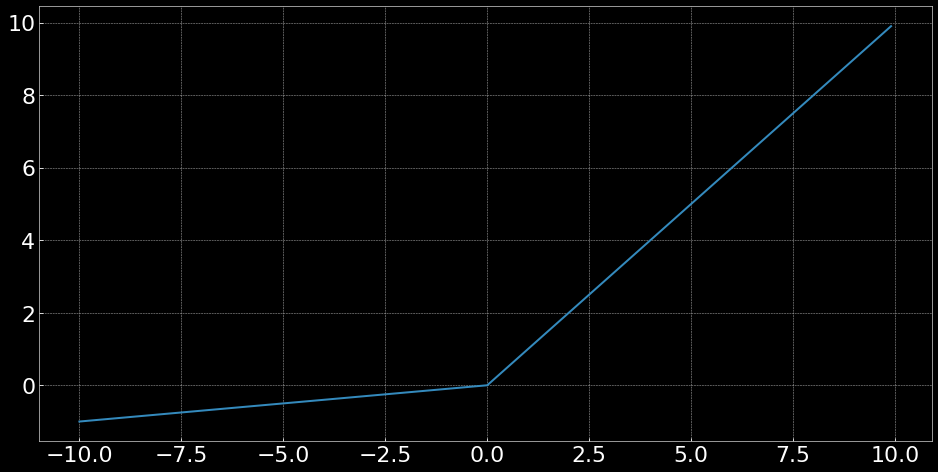

In [29]:
x = np.arange(-10, 10, 0.1)
y = np.arange(-10, 10, 0.1)
y[x < 0] = 0.1 * x[x < 0]
plt.plot(x, y)

Lastly, I should mention the activation function called SoftMax. SoftMax is only used at the very end of a neural network. The purpose of softmax is to convert a bunch of scores that the neural network has computed into probabilities. For example, if we have a ReLU activation function at the end of our neural network, then the output is not bounded to be between $[0, 1]$ or even $[-1, 1]$ like in the `tanh` case. If I had computed the "scores" for say 10 different classes then we would like some meaningful way of converting these scores into probabilities for each class. The way to do this is with the SoftMax function

$$
SoftMax(x_i) =  \frac{e^{x_i}}{\sum_{j=1}^{N} e^{x_j}}
$$

where this would be equivalent to a probability for the $i^{th}$ score and N is the total number of scores. The intuition for the SoftMax function comes from statistical mechanics where $x_i$ is the energy of the $i^{th}$ configuration.

Now we can see that the bias term originally in our single layer perceptron model can take on an entirely new interpretation! That is, instead of interpreting the bias as the axis intercept for our model, we can interpret it as allowing for the activation function to "slide around"! Try it out yourself!

In [30]:
b = 2 # bias term, feel free to change this around

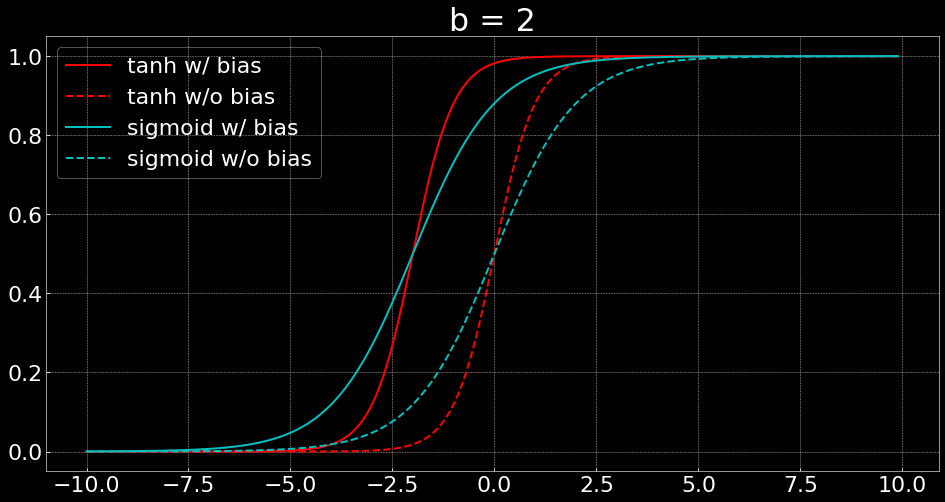

In [31]:
y = (np.tanh(x + b) + 1) / 2
plt.plot(x, y, label='tanh w/ bias', color='r')
y = (np.tanh(x) + 1) / 2
plt.plot(x, y, label='tanh w/o bias', linestyle='--', color='r')
y = 1 / (1 + np.exp(-(x + b)))
plt.plot(x, y, label='sigmoid w/ bias', color='c')
y = 1 / (1 + np.exp(-(x)))
plt.plot(x, y, label='sigmoid w/o bias', linestyle='--', color='c')
plt.title('b = ' + str(b))
plt.legend()

So what is this activation function really *doing*? It is simply taking these angles in as inputs and when these angles are less than 90 degrees, the activation functions are mapping these angles to a value that would be equivalent to an even smaller angle (by mapping it to a more positive value) and when these angles are greater than 90 degrees the activation functions map these angles to a value that would be equivalent to an even greater angle. We can imagine the activation function as sort of squeezing the datapoints to be more aligned with the parameter vector $\vec{\theta}$. On top of this, the bias allows us to change where this cutoff angle is, meaning that it could be less than 75 degrees where these angles get pushed more towards smaller angles and greater than 75 degrees where these angles get pushed towards larger angle values.

If you were wondering, we can express this neural network with diagrams!
![title](images/single-layer-perceptron-in-tensorflow2.png)

Now wait a second... what are these weights?! Don't worry, this is just $\vec{\theta}$. For some reason, we decided when talking about neural networks we prefer to call the parameters of the model the weights or the weight vector $\vec{w}$. There's also nothing to say that we can't have multiple outputs for a single single-layer perceptron!

![title](images/singlelayer.svg)

However, we need to change our notation a tad here. Notice that for a single output node in the output layer, we only had one set of weights meaning we could just do a simple dot product between the weight vector and the input vector. Now we have multiple weight vectors with each weight vector corresponding to each output node. Therefore, we want something that looks like this
$$
\left[
\begin{array}
    \vec{w_1} \cdot \vec{x} \\
    \vec{w_2} \cdot \vec{x} \\
     . \\
     . \\
     . \\
    \vec{w_n} \cdot \vec{x} \\
\end{array}
\right]
$$

which is just matrix multiplication where we now have the weight matrix! Therefore, let's update our notation for a single layer perceptron! 

$$
\hat{y} = \mathcal{f}\left(\stackrel{\leftrightarrow}{W}\cdot\vec{x} + b\right)
$$

Also, by the way, those "nodes" in that graph shown above are called "neurons" which consist of a summing unit and a nonlinearity (activation function). 

As a last example, I will show below how activation functions can transform data non-linearly. Here's the function we will be using:
$$
   f(x)= \tanh \left(
  \left[ {\begin{array}{cc}
   s & 0 \\
   0 & s \\
  \end{array} } \right]  
  \cdot \vec{x}
  \right)
$$
which means this is equivalent to a single-layer perceptron predicting two new numbers and the weight matrix is parametrized by a single parameter $s$ which we will be increasing to see how that changes the transformation.

In [32]:
# utility function
def show_scatterplot(X, norm=True, title=''):
    X = X.numpy()
    plt.figure()
    plt.axis('equal')
    plt.scatter(X[:, 0], X[:, 1], c=colors, s=p_size)
    if norm:
        plt.xlim(-6, 6)
        plt.ylim(-6, 6)
    plt.grid(True)
    plt.title(title)

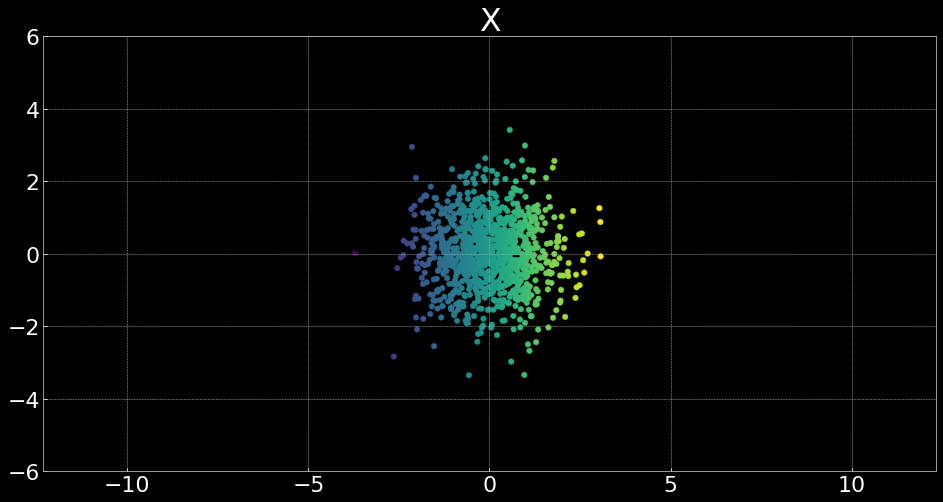

In [33]:
# generate some points in 2-D space
n_points = 1000
p_size = 30
X = torch.randn(n_points, 2) 
colors = X[:, 0].numpy() 

show_scatterplot(X, norm=True, title='X')

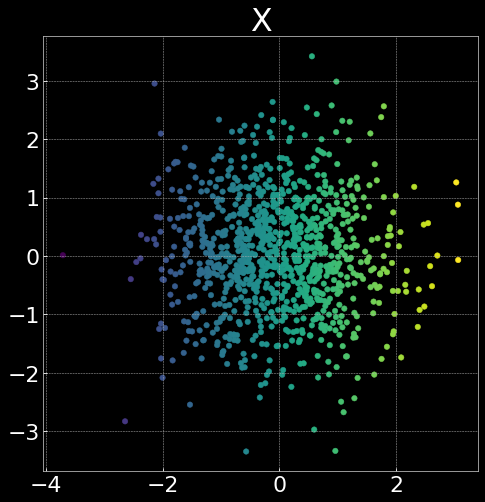

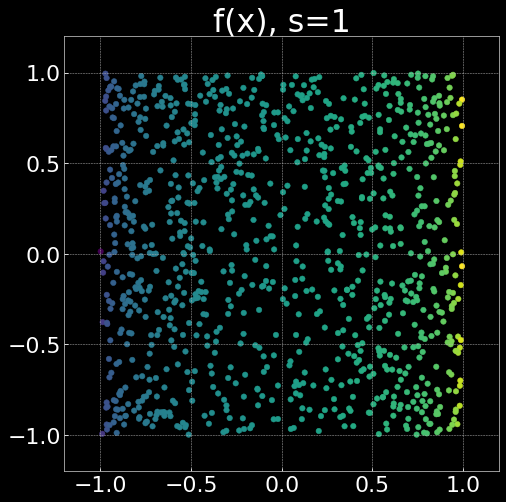

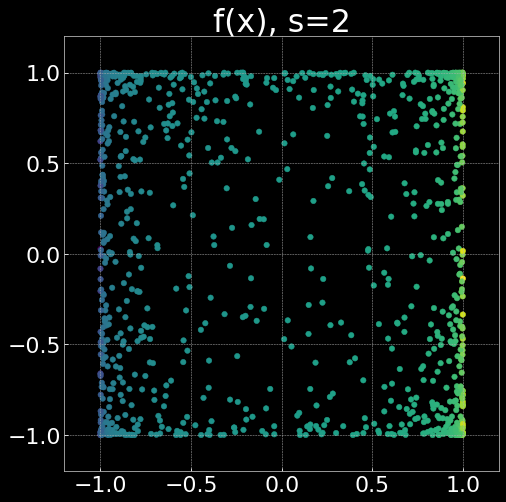

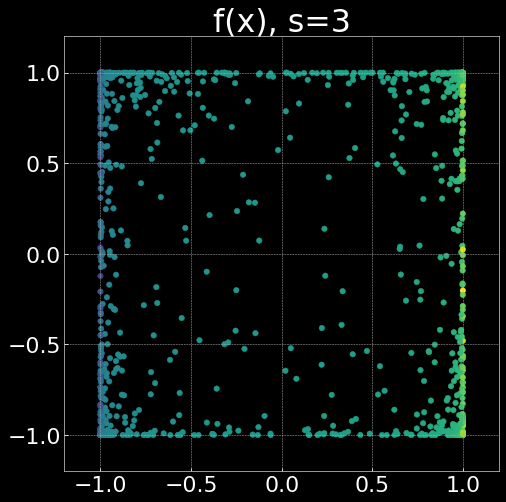

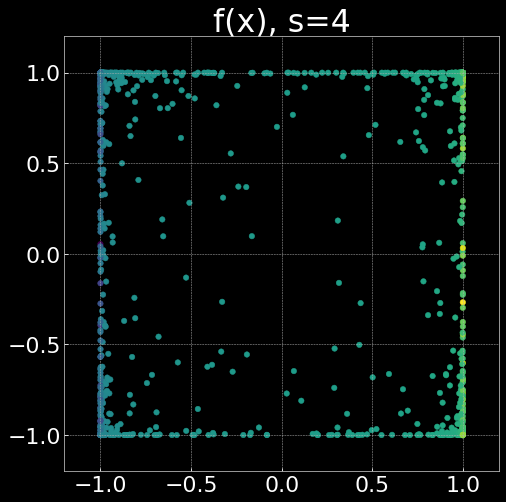

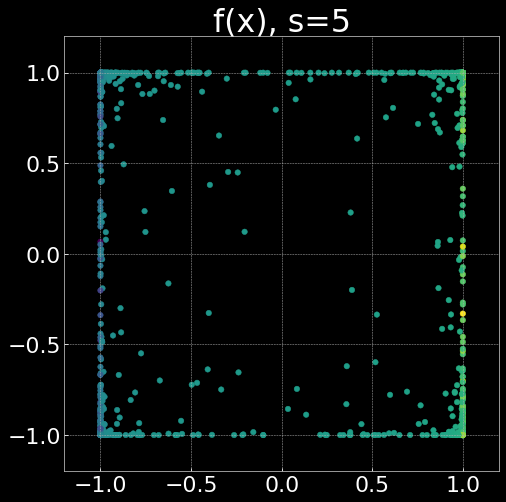

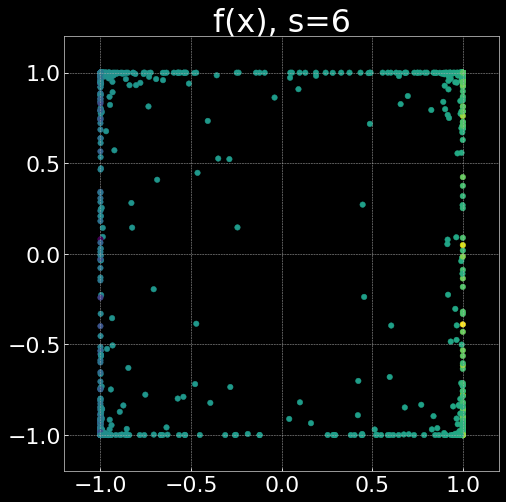

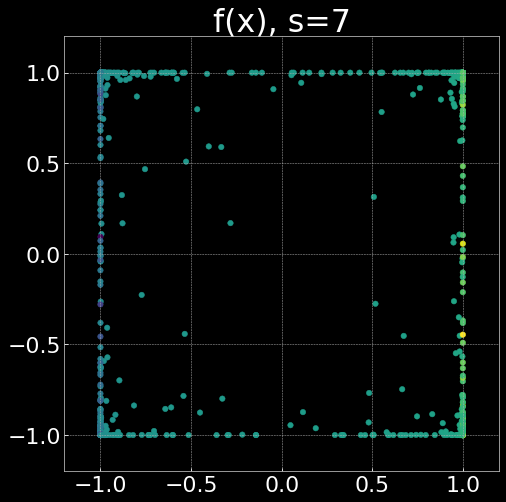

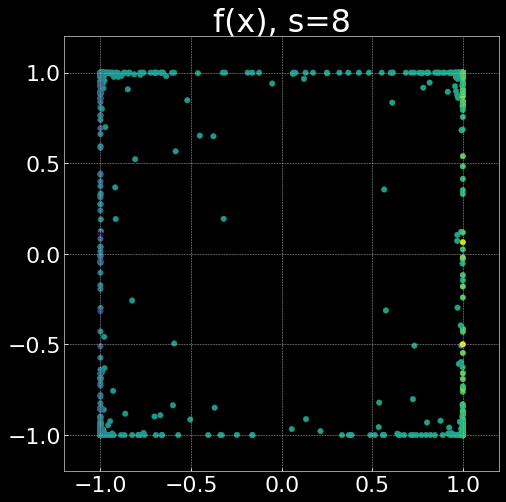

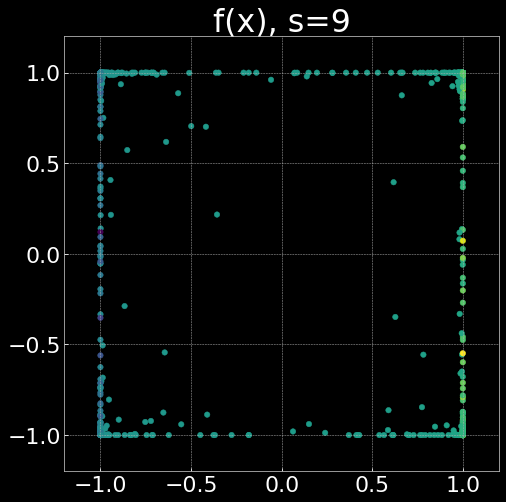

In [34]:
show_scatterplot(X, title='X')
plt.axis('square')

# This is the single-layer perceptron
model = nn.Sequential(
        nn.Linear(2, 2, bias=False), # This is where we define W, note bias = False!
        nn.Tanh() # This is then the non-linearity
    )

for s in range(1, 10):
    W = s * torch.eye(2) # W = [[s, 0], [0, s]]
    model[0].weight.data.copy_(W) # set the model's parameters to W
    Y = model(X).data # grab the model's predictions
    
    # plot the predictions
    show_scatterplot(Y, False, title='f(x), s={}'.format(s)) 
    plt.axis('square')
    plt.axis([-1.2, 1.2, -1.2, 1.2])

Just to re-cap, a single-layer perceptron or a single-layer feed-forward neural network is a linear classifier that uses an activation function as a way to transform the data to boost the accuracy of the model.

# Multi-layer Perceptrons
We just learned that single-layer feed-forward neural networks are great linear classifiers. However, what if you have data which is not linearly separable? Such as the below case:

In [35]:
N_ones = 1000
N_zeros = 100

In [36]:
X_ones = torch.cat((torch.randn(N_ones, 2) / 15, (torch.randn(N_ones, 2) / 15) + 1))
X_zeros = torch.cat(((torch.randn(N_zeros, 2) / 15) + torch.Tensor([0, 1]), (torch.randn(N_zeros, 2) / 15) + torch.Tensor([1, 0])))

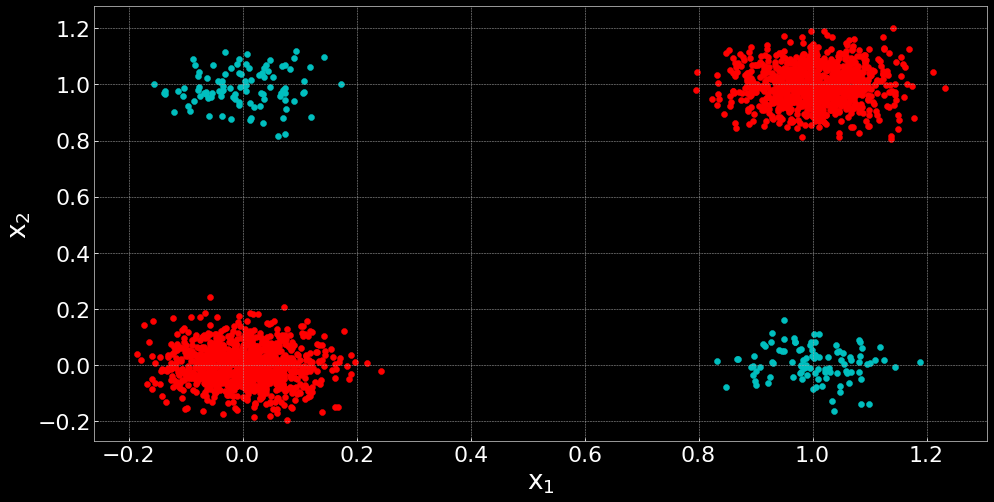

In [37]:
plt.scatter(X_ones[:,0], X_ones[:, 1], label='$\hat{y} = 1$', color='r')
plt.scatter(X_zeros[:,0], X_zeros[:, 1], label='$\hat{y} = 0$', color='c')
plt.xlabel('$\mathregular{x_1}$')
plt.ylabel('$\mathregular{x_2}$')
plt.show()

Clearly there is no line that I can draw here that will separate the red data points from the blue data points (this is called the XOR problem, a historically very important problem in artificial intelligence research). I need to draw some curved **decision boundary** in order to be able to separate these two classes. A multilayer perceptron will be able to solve this problem!

![title](images/mlp.svg)

A multilayer perceptron (sometimes abbreviated MLP) is the same thing as a single-layer perceptron except that you can have additional layers of neurons. These additional layers are called hidden layers and can help the neural network to learn deeper, richer, representations of the data. As an example, imagine I performed the non-linear transformation $z = (2 x_1 - 1)(2 x_2 - 1)$. This new variable would cause the above data to become linearly separable. Go ahead, try it out!

However, in most scenarios you do not know the underlying required transformation to make your data linearly separable again. Therefore, you must be able to blindly apply a model which will learn the necessary non-linear transformations to make your data linearly separable again. This model is the multilayer perceptron. Let's try and solve the XOR problem!

In [38]:
# Create the model
model = nn.Sequential(
    nn.Linear(2, 2), # the weight matrix, mapping a 2D input to a 2 neuron hidden layer
    nn.ReLU(), # apply non-linearity after weight matrix
    nn.Linear(2, 1), # another weight matrix, mapping from 2 hidden neurons to 1D output neuron/layer
    nn.Sigmoid() # pass output through sigmoid to get predictions in terms of 0/1
    )

In [39]:
# Concatenate the data together and create labels
data = torch.cat((X_ones, X_zeros))
labels = torch.cat((torch.ones(len(X_ones)), torch.zeros(len(X_zeros))))

Now we need to prepare the data for the model. There's three considerations we need to take into consideration when preparing data for a model:

  * "Standardizing" the data
  
This means subtracting the mean and dividing by the standard deviation of each dimension of the input vector. This is useful for optimization purposes. If we have a single dimension which is 1000x larger than the other input dimensions, the optimizer will notice that making small changes to the weights associated with this input dimension will have a much larger impact on the loss and therefore will only focus on optimizing these weights. An analogy often used is imagine a soup bowl with a large rim. The optimizer basically sees this soup bowl as the optimization surface and so will get stuck on the rim after it has optimized the weights associated with this parameter and can't "see" this finer structure that is the soup bowl in the middle.

In [40]:
mean = torch.mean(data, 0)
stdev = torch.std(data, 0, True)

  * Training/Validation/Testing data split
  
We have to use some of our data for training the model. However, there becomes a point in which the model can "overfit" and start memorizing the data. What this means is that even though the model may be claiming a 99.99% accuracy, if you give it data it has never trained on it might only be 10% accurate. Another word people like using here is the model is "overtrained". The way you can identify when this starts occuring is by having a validation dataset. 

A validation dataset is a dataset you use to see how well your model is performing on data it has never trained on. Typically, over the course of training your model you will periodically check the performance of your model on the training dataset and the validation dataset. You will then keep a copy of the model that performed the best on your validation dataset. Eventually, you will reach a point in which your model will start memorizing and that is when you stop training. 


The testing dataset is used to then further validate your model by performing one last crosscheck to ensure that there wasn't any bias present in your validation dataset that led you to believe you were performing well when actually on a second dataset you have not trained on you perform very poorly on. This will only be the case when your validation dataset is of a small sample size or your dataset is very inhomogenous meaning that even with a very large dataset you could have a very large variance in that data being presented. 

One possible technique for minimizing this possible bias is by performing what is called k-fold cross validation. This is where you train and validate your model multiple times on different splits of the data. You can imagine breaking your dataset into k chunks and using k-1 chunks for training and 1 chunk for validation and then cycling through the chunks you use for validation. If you see a very consistent validation performance timeline for all k-folds then you know that your validation sample size is large enough with respect the variance within your dataset.

A common question people pose is how large should my validation/training/testing datasets be. Essentially you want your training set as large as possible such that you still have enough statistics within your validation/testing sest that you are not susceptible to the biases outlined above (too large of variance within your validation/testing sets).

In [41]:
train_split = 0.7 # 70% of the data is training
valid_split = 0.2 # 20% of the data is validation
test_split = 0.1 # 10% of the data is testing

num_ones = len(X_ones) # calculate total number of data points with class labels = 1
num_zeros = len(X_zeros) # calculate total number of data points with class labels = 0

# split the data into training data
training_data = torch.cat((X_ones[:int(num_ones * train_split)], X_zeros[:int(num_zeros * train_split)]))
# split the labels for just training data
training_labels = torch.cat((torch.ones(int(num_ones * train_split)), torch.zeros(int(num_zeros * train_split))))

# split the data into validation data
validation_data = torch.cat((X_ones[int(num_ones * train_split):int(num_ones * (train_split + valid_split))],
                             X_zeros[int(num_zeros * train_split):int(num_zeros * (train_split + valid_split))]))
validation_labels = torch.cat((torch.ones(int(num_ones * valid_split)), torch.zeros(int(num_zeros * valid_split))))

# split the data into testing data
test_data = torch.cat((X_ones[int(num_ones * (train_split + valid_split)):],
                      X_zeros[int(num_zeros * (train_split + valid_split)):]))
test_labels = torch.cat((torch.ones(int(num_ones * test_split)), torch.zeros(int(num_zeros * test_split))))

  *  Class imbalance issues
  
Class imbalance issues arise when there are more examples of one class than another in the training set. The reason this is an issue in the first place is because your model will learn to not care about certain classes. For example, if your data consists of 99% of class A and 1% of class B, then your model will learn quite quickly by just always guessing class A it can achieve a 99% accuracy. So it may have a 0% accuracy on correctly labeling class B but it has an overall very good accuracy. The method of solving this is to either upsample (duplicate) samples in your classes that have fewer examples or to downsample (toss out) samples in your classes that have more examples. Clearly neither of these are ideal and its hard to say which one to perform or which is better. Typically, when you have lots of data for all of your classes (number of samples in smallest class >>> number of parameters in your model) you can perform downsampling and not sacrifice much performance. Similarly, if you do not have a lot of data, you can typically perform upsampling to get further performance boosts out of your model. **Note: You must split your data into your training/validation samples before performing upsampling so as to not accidentally leak your duplicated samples from your training set into your validation set thus leading to a false belief that your model is performing quite well.**

In [43]:
num_ones_in_training = int(train_split * num_ones)
num_zeros_in_training = int(train_split * num_zeros)



In [46]:
if num_ones_in_training > num_zeros_in_training: # need to downsample the ones
    training_data = torch.cat((training_data[training_labels == 1][:num_zeros_in_training], training_data[training_labels == 0]))


tensor([[-0.0390, -0.0010],
        [-0.0643,  0.0082],
        [ 0.0870,  0.0592],
        ...,
        [ 0.9962, -0.0109],
        [ 0.9172,  0.0685],
        [ 1.0104, -0.0155]])